Dataset shape: (4999, 6)
Column list: Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
Specialities: medical_specialty
Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
O

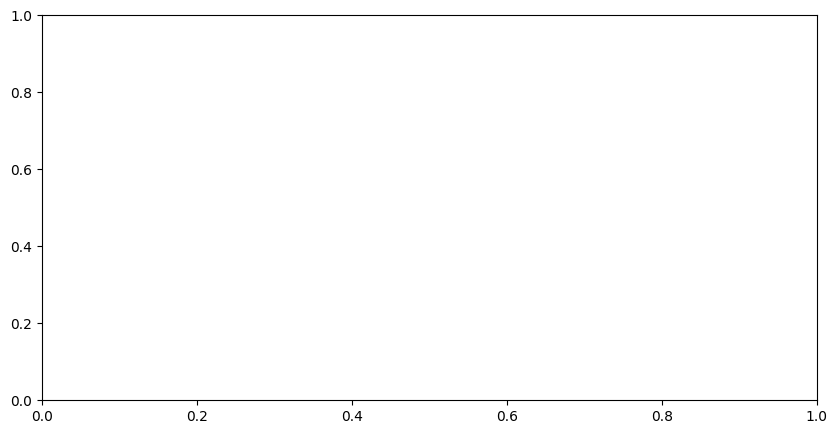

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

try:
    df = pd.read_csv('C:/Users/Admin/Documents/ResearchProject/mtsamples.csv')
    print(f'Dataset shape: {df.shape}')
    print(f'Column list: {df.columns}')
    df['transcription'] = df['transcription'].fillna('') #To handle missing values

    specialities = df['medical_specialty'].value_counts()
    print(f'Specialities: {specialities}')

    plt.figure(figsize=(10,5))
    specialities.plot(kind='bar', color='peach')
    plt.title("All medical specialities in the dataset")
    plt.ylabel("Number of Transcripts")
    plt.show()
    

except Exception as e:
    print("Error:", str(e))
    if 'df' in locals():
        print("\nAvailable specialties:", df['medical_specialty'].unique())

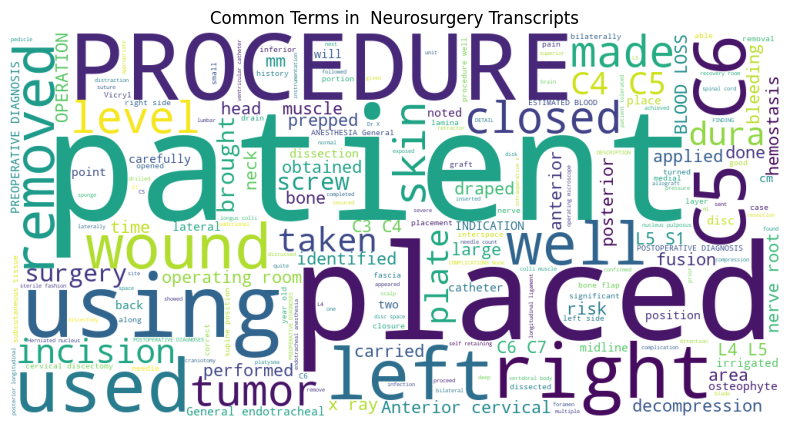

In [2]:
try:
    speciality = ' Neurosurgery'
    if speciality in df['medical_specialty'].values:
        texts = df[df['medical_specialty']==speciality]['transcription']
        if not texts.empty:
            text = ' '.join(texts.astype(str))
            if len(text.strip()) > 0:
                wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
                plt.figure(figsize=(10,5))
                plt.imshow(wordcloud)
                plt.axis("off")
                plt.title(f"Common Terms in {speciality} Transcripts")
                plt.show()
    
            else:
                print(f"No valid text found for {speciality}")
        else:
            print(f"No transcriptions available for {speciality}")
    else:
        print("Speciality not found in dataset")

except Exception as e:
    print("Error:", str(e))

In [3]:
import re
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


nltk.download(['stopwords', 'punkt'], quiet=True)

def clean_text(text):
    if not isinstance(text, str):
        return ""

    medical_terms = {
        'dr', 'pt', 'mr', 'mri', 'ct', 'hr', 'bp', 'rr', 'spo2', 
        'ekg', 'cbc', 'er', 'or', 'ed', 'icu', 'lab'
    }
    try:
        text = text.lower()
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\b\d+[\.\d]*\b', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
    
        words = word_tokenize(text)
        stop_words = set(stopwords.words('english')) - medical_terms
        filtered_words = []

        for word in words:
            if word not in stop_words and len(word)>1:
                filtered_words.append(word)

        words = filtered_words

        return ' '.join(words)
        
    except Exception as e:
        print(f'Error while processing the text!: {e}')

tqdm.pandas(desc="Cleaning Text")

df['clean_text'] = df['transcription'].progress_apply(clean_text)

empty_text = df['clean_text'].str.strip().eq('').sum()

print(f"\nDiagnostics:")
print(f" Original samples: {len(df)}")
print(f" Empty results: {empty_text} ({empty_text/len(df):.1%})")
print("\nSample Before:\n", df['transcription'].iloc[0][:200])
print("\nSample After:\n", df['clean_text'].iloc[0][:200])
        

Cleaning Text: 100%|██████████████████████████████████████████████████████████████| 4999/4999 [00:21<00:00, 233.49it/s]


Diagnostics:
 Original samples: 4999
 Empty results: 33 (0.7%)

Sample Before:
 SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried 

Sample After:
 subjective year old white female presents complaint allergies used allergies lived seattle thinks worse past tried claritin zyrtec worked short time seemed lose effectiveness used allegra also used la


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

top_specialties = df['medical_specialty'].value_counts().head(5).index.tolist()

df_top_specialties = df[df['medical_specialty'].isin(top_specialties)].copy()

if len(df_top_specialties) < 150:
    print(f"Insufficient data. Size = {len(df_top_specialties)}")

word_vectorizer = TfidfVectorizer(max_features=750, stop_words='english')

X = word_vectorizer.fit_transform(df_top_specialties['clean_text'])
y = df_top_specialties['medical_specialty']

# Splitting the filtered dataset df_top_specialties into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print(f"Classification Report: \n{classification_report(y_test, y_pred_nb)}")

Classification Report: 
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.55      0.32      0.40        82
 Consult - History and Phy.       0.75      0.97      0.85       116
                 Orthopedic       0.41      0.39      0.40        67
                  Radiology       0.60      0.71      0.65        45
                    Surgery       0.78      0.76      0.77       214

                   accuracy                           0.69       524
                  macro avg       0.62      0.63      0.61       524
               weighted avg       0.67      0.69      0.67       524



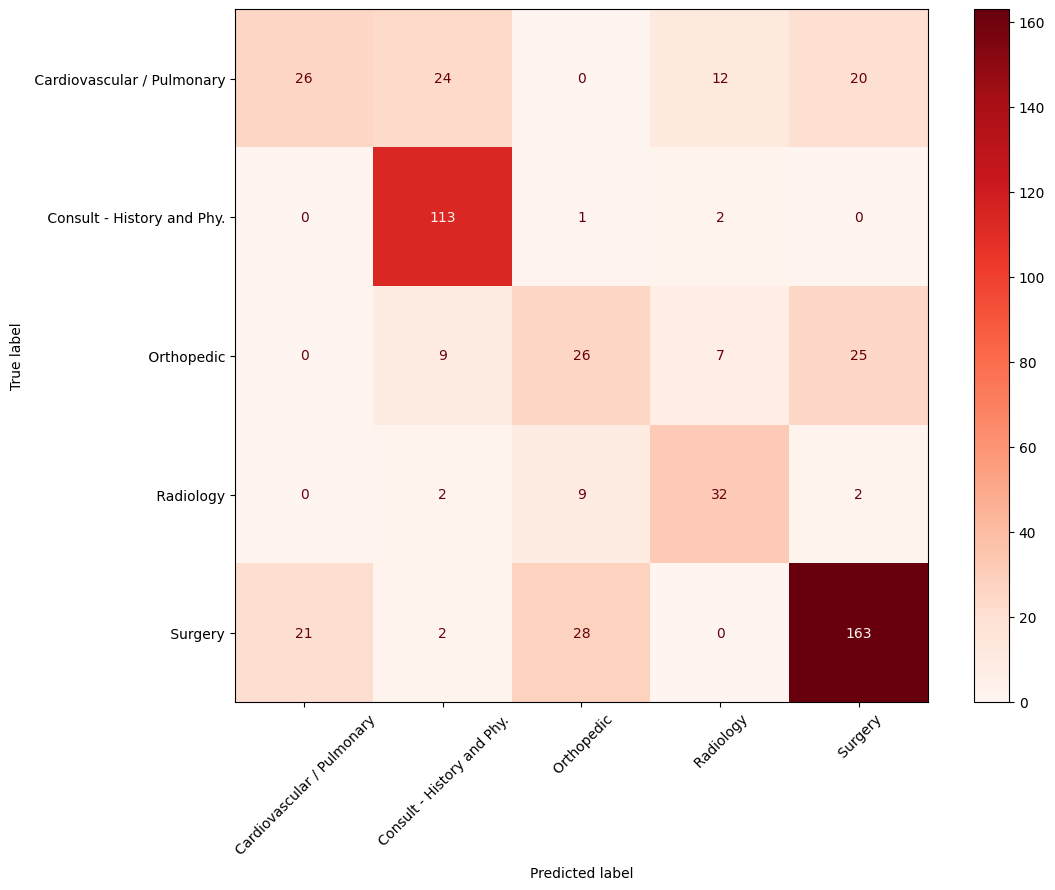

In [5]:
fig, ax = plt.subplots(figsize=(12, 9))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_nb,
    display_labels=nb_model.classes_,
    xticks_rotation=45,
    cmap='Reds',
    ax=ax)

In [6]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Classification Report: (Linear SVC)\n{classification_report(y_test, y_pred_svc)}")

Classification Report: (Linear SVC)
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.30      0.20      0.24        82
 Consult - History and Phy.       0.82      0.86      0.84       116
                 Orthopedic       0.19      0.21      0.20        67
                  Radiology       0.45      0.64      0.53        45
                    Surgery       0.67      0.67      0.67       214

                   accuracy                           0.58       524
                  macro avg       0.49      0.52      0.50       524
               weighted avg       0.57      0.58      0.57       524



In [7]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print(f"Classification Report (Logistic Regression): \n{classification_report(y_test, y_pred_lr)}")

Classification Report (Logistic Regression): 
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.42      0.24      0.31        82
 Consult - History and Phy.       0.82      0.93      0.87       116
                 Orthopedic       0.34      0.28      0.31        67
                  Radiology       0.50      0.69      0.58        45
                    Surgery       0.73      0.77      0.75       214

                   accuracy                           0.65       524
                  macro avg       0.56      0.58      0.56       524
               weighted avg       0.63      0.65      0.64       524



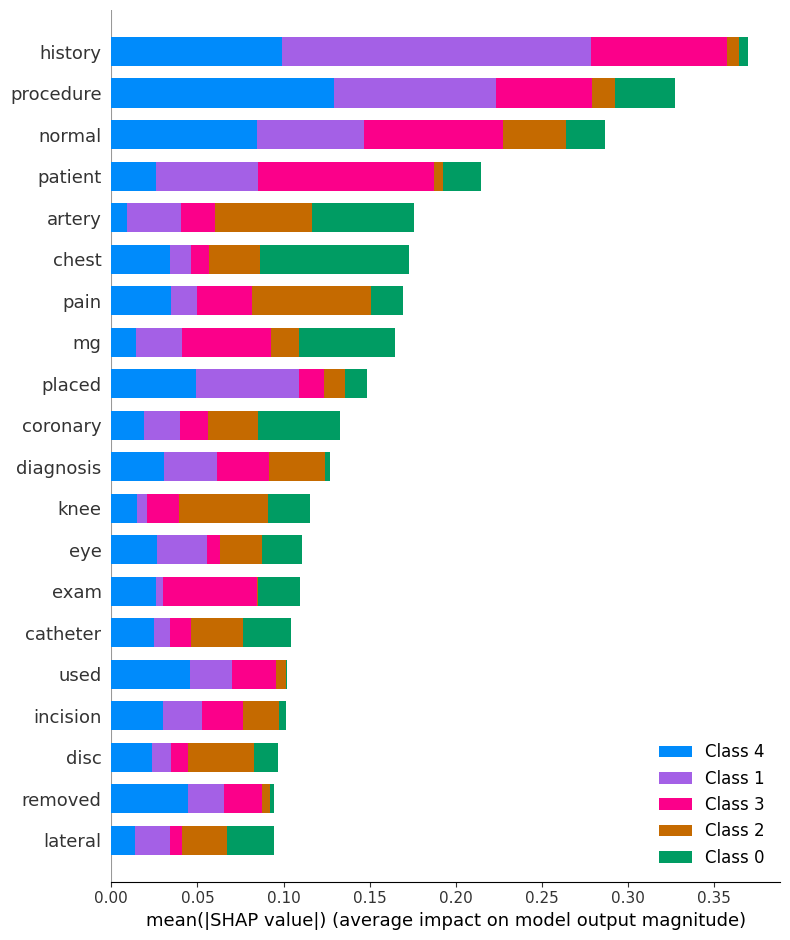

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (750, 5)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [8]:
# XAI using SHAP

import shap
import xgboost
from sklearn.preprocessing import LabelEncoder

explainer = shap.Explainer(lr_model, X_train.toarray())
shap_values = explainer(X_test.toarray())

shap.summary_plot(shap_values, X_test.toarray(), feature_names=word_vectorizer.get_feature_names_out())
shap.plots.waterfall(shap_values[0])

In [9]:
#XAI using eli5

import eli5
from eli5.sklearn import explain_weights
eli5.show_weights(lr_model, feature_names=word_vectorizer.get_feature_names_out())

In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

ensemble_model = VotingClassifier(
    estimators=[('nb', nb_model), ('lr', lr_model), ('svc', svc_model)],
    voting='hard'
)
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)


In [11]:
accuracy_data = {
    "Model": ["MultinomialNB", "Logistic Regression", "Linear SVC", "Voting Ensemble"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svc),
        accuracy_score(y_test, y_pred_ensemble)
    ]
}
accuracy_df = pd.DataFrame(accuracy_data)
print("Accuracy Comparison:\n")
print(accuracy_df.to_string(index=False))

Accuracy Comparison:

              Model  Accuracy
      MultinomialNB  0.687023
Logistic Regression  0.654580
         Linear SVC  0.576336
    Voting Ensemble  0.641221


In [12]:
print("\n Classification Report - MultinomialNB:\n")
print(classification_report(y_test, y_pred_nb))

print("\n Classification Report - Logistic Regression:\n")
print(classification_report(y_test, y_pred_lr))

print("\n Classification Report - Linear SVC:\n")
print(classification_report(y_test, y_pred_svc))

print("\n Classification Report - Voting Ensemble:\n")
print(classification_report(y_test, y_pred_ensemble))


 Classification Report - MultinomialNB:

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.55      0.32      0.40        82
 Consult - History and Phy.       0.75      0.97      0.85       116
                 Orthopedic       0.41      0.39      0.40        67
                  Radiology       0.60      0.71      0.65        45
                    Surgery       0.78      0.76      0.77       214

                   accuracy                           0.69       524
                  macro avg       0.62      0.63      0.61       524
               weighted avg       0.67      0.69      0.67       524


 Classification Report - Logistic Regression:

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.42      0.24      0.31        82
 Consult - History and Phy.       0.82      0.93      0.87       116
                 Orthopedic       0.34      0.28      0.31        67
         

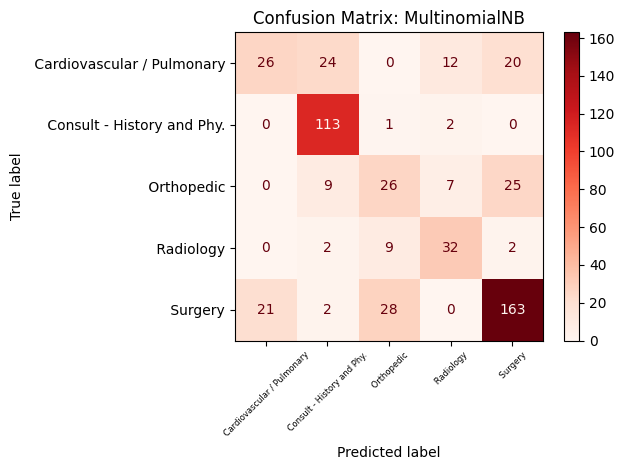

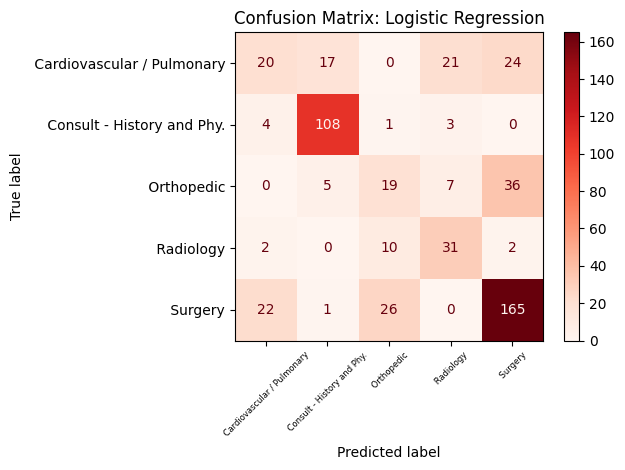

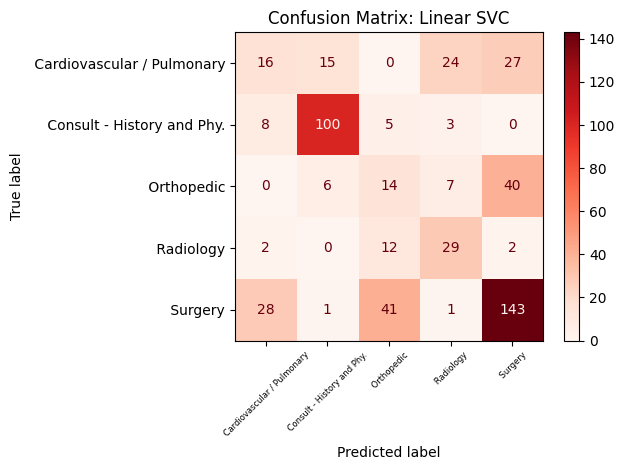

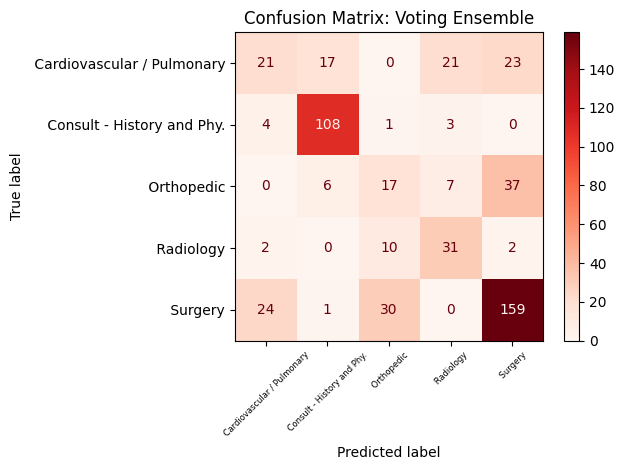

In [13]:
models = {
    "MultinomialNB": nb_model,
    "Logistic Regression": lr_model,
    "Linear SVC": svc_model,
    "Voting Ensemble": ensemble_model
}

for name, model in models.items():
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Reds', xticks_rotation=45)
    disp.ax_.set_title(f'Confusion Matrix: {name}')
    disp.ax_.tick_params(axis='x', labelsize=6)
    plt.tight_layout()
    plt.show()

In [14]:
# Stacked Ensemble

from sklearn.ensemble import StackingClassifier
base_learners = [
    ('nb', MultinomialNB()),
    ('lr', LogisticRegression(max_iter=1000)),
    ('svc', LinearSVC())
]

meta_learner = LogisticRegression(max_iter=2000, solver='liblinear')

stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=False,  
    cv=5               
)

stacked_model.fit(X_train, y_train)
y_pred_stacked = stacked_model.predict(X_test)

print(" Classification Report - Stacked Ensemble:\n")
print(classification_report(y_test, y_pred_stacked))

print(f" Accuracy (Stacked Ensemble): {accuracy_score(y_test, y_pred_stacked):}")

 Classification Report - Stacked Ensemble:

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.48      0.26      0.33        82
 Consult - History and Phy.       0.81      0.92      0.86       116
                 Orthopedic       0.40      0.31      0.35        67
                  Radiology       0.51      0.78      0.61        45
                    Surgery       0.76      0.80      0.78       214

                   accuracy                           0.68       524
                  macro avg       0.59      0.61      0.59       524
               weighted avg       0.66      0.68      0.66       524

 Accuracy (Stacked Ensemble): 0.6793893129770993


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Neural Network implementation

le = LabelEncoder()
y_encoded = le.fit_transform(y)     # y = df_top_specialties['medical_specialty']

# train-test split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X, y_encoded, test_size=0.2, random_state=36
)

X_train_nn_dense = X_train_nn.toarray()
X_test_nn_dense = X_test_nn.toarray()

num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_nn, num_classes)
y_test_cat = to_categorical(y_test_nn, num_classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn_dense.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_nn_dense, y_train_cat,
    validation_data=(X_test_nn_dense, y_test_cat),
    epochs=15,
    batch_size=32
)

loss, accuracy = model.evaluate(X_test_nn_dense, y_test_cat, verbose=0)
print(f"Neural Network - Test Accuracy: {accuracy:.4f}")


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5432 - loss: 1.2992 - val_accuracy: 0.6431 - val_loss: 0.9426
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6592 - loss: 0.8795 - val_accuracy: 0.7023 - val_loss: 0.7340
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7103 - loss: 0.7256 - val_accuracy: 0.6718 - val_loss: 0.6737
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7236 - loss: 0.6348 - val_accuracy: 0.6622 - val_loss: 0.6354
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7341 - loss: 0.5848 - val_accuracy: 0.6412 - val_loss: 0.6303
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7465 - loss: 0.5416 - val_accuracy: 0.6641 - val_loss: 0.6582
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7346 - loss: 0.5325 - val_accuracy: 0.6298 - val_loss: 0.6555
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7484 - loss: 0.4979 - val_accuracy: 0.6164 - val_los

In [16]:
# Classification Report

import numpy as np
from sklearn.metrics import classification_report

y_pred_proba = model.predict(X_test_nn_dense)
y_pred_nn = np.argmax(y_pred_proba, axis=1)
print("Classification Report (Neural Network):\n", classification_report(y_test_nn, y_pred_nn, target_names=le.classes_))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Report (Neural Network):
                              precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.25      0.15      0.18        82
 Consult - History and Phy.       0.83      0.84      0.84       116
                 Orthopedic       0.20      0.22      0.21        67
                  Radiology       0.45      0.64      0.53        45
                    Surgery       0.66      0.68      0.67       214

                   accuracy                           0.57       524
                  macro avg       0.48      0.51      0.49       524
               weighted avg       0.56      0.57      0.56       524

